In [693]:
import pandas as pd
import numpy as np
import psycopg2
import pandas.io.sql as sqlio
import datetime
import statsmodels.api as sm
import xgboost as xgb
import seaborn as sb
import matplotlib.pyplot as plt

from google.cloud import bigquery
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression

Забираем данные, какие?

- Тип доставки

- Номер заказа

- Первый ли заказ

- Была ли применена скидка

- Группа RFM

- Платформа

- День недели

- Отложенный/Быстрый заказ

- Был ли новогодний подарок в корзине

- Были ли добавлены товары из рекомендаций

- Присутствует ли в корзине алкоголь

- Среднее количество товаров в корзине в предыдущих заказах пользователя

- PV в день заказа

- Сталкивался ли с алертом о максимуме продуктов

### Вспомогательные функции

In [749]:
def draw_plot_feature_importance(X_train: pd.DataFrame, indices: [], title: str) -> None:
    """"""
    names = [X_train.columns[i] for i in indices]

    plt.figure(figsize = (12, 5))
    sns.set_style("whitegrid")
    chart = sns.barplot(x=names, y=importances[indices])
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light'  
    )
    plt.title(title)
    plt.tight_layout()

    plt.savefig(f'{title}.png', dpi=200)
    return 

### Выбираем период с 1 ноября по 25 декабря

In [694]:
CONN_GLOBAL = psycopg2.connect(dbname='wuplo_prod', user='sophiedata', 
                        password='DgYDq6WFr47#Etyuu@', host='db.wuplo.internal')

In [695]:
conn = CONN_GLOBAL
sql = '''
with orders_view as (
    select
        trequests.dateclose:: date as date,
        trequests.id as id_request,
        trequests.id_creator as user_id,
        trequests.id_deliverytype,
        trequests.creator_request_num,
        case when trequests.creator_request_num = 1 then 1 else 0 end as first_order,
        trequests.productcost_amount,
        trequests.productcost_without_discount_amount,
        case when trequests.id_discount is null then 0 else 1 end as use_discount,
        tusers.rfm,
        case when trequests.source = 'iOS' then 0
            when trequests.source = 'Android' then 1
            when trequests.source = 'Web' then 2 else -1 end as platform,
        extract(dow from trequests.dateopen) as dow_dateopen,
        case
            when trequests.id_deliverytype = 1 and extract(epoch from (trequests.dateto - trequests.dateopen)) / 60.0 < 70
            or trequests.id_deliverytype = 2 and extract(epoch from (trequests.dateto - trequests.dateopen)) / 60.0 < 40
            or trequests.id_deliverytype = 3 and extract(epoch from (trequests.dateto - trequests.dateopen)) / 60.0 < 25
            then 0
            else 1
        end as delayed_order,
        case when trequestitems.analytics_position_in_recommendation IS NOT NULL
                    and trequestitems.analytics_total_in_recommendation is not null then 1 else 0 end as is_recommended,
        case when trequestitems.is_alcoholic then 1 else 0 end as is_alcoholic,
        case when trequests.gift_extra_num is not null then 1 else 0 end as gift_extra_num,
        trequestitems.count
    from trequests
    inner join trequestitems on trequests.id = trequestitems.id_request
    inner join tusers on tusers.id = trequests.id_creator
    where trequests.status = 9
        and trequests.addstatus = 91
        and trequests.dateclose >= '2021-10-31 23:00:00'
        and trequests.dateclose < '2021-12-25 23:00:00'
),

prepare_view as (
    select
        date,
        id_request,
        user_id,
        id_deliverytype,
        creator_request_num,
        first_order,
        productcost_amount,
        productcost_without_discount_amount,
        use_discount,
        rfm,
        platform,
        dow_dateopen,
        delayed_order,
        gift_extra_num,
        sum(is_recommended) as is_recommended,
        sum(is_alcoholic) as is_alcoholic,
        sum(count) as cnt_items
    from orders_view
    group by date, id_request, user_id, id_deliverytype, creator_request_num,
             first_order, productcost_amount, productcost_without_discount_amount,
             use_discount, rfm, platform, dow_dateopen, delayed_order, gift_extra_num
),

finally_view as (
    select
        date,
        id_request,
        user_id,
        id_deliverytype,
        creator_request_num,
        first_order,
        productcost_amount,
        productcost_without_discount_amount,
        use_discount,
        rfm,
        platform,
        dow_dateopen,
        delayed_order,
        gift_extra_num,
        case when is_recommended > 0 then 1 else 0 end as is_recommended,
        case when is_alcoholic > 0 then 1 else 0 end as is_alcoholic,
        cnt_items
    from prepare_view
)


    select
        finally_view.date,
        finally_view.id_request,
        finally_view.user_id,
        finally_view.id_deliverytype,
        finally_view.creator_request_num,
        finally_view.first_order,
        finally_view.productcost_amount,
        finally_view.productcost_without_discount_amount,
        finally_view.use_discount,
        finally_view.rfm,
        finally_view.platform,
        finally_view.dow_dateopen,
        finally_view.delayed_order,
        finally_view.gift_extra_num,
        finally_view.is_recommended,
        finally_view.is_alcoholic,
        finally_view.cnt_items,
        avg(t.cnt_items) as prev_cnt_items
    from finally_view
    left join (
        select
            trequests.id_creator,
            trequests.id as id_request,
            trequests.dateclose,
            sum(trequestitems.count) as cnt_items
        from trequests
        inner join trequestitems on trequests.id = trequestitems.id_request
        group by trequests.id_creator, trequests.id, trequests.dateclose
    ) as t on t.id_creator = finally_view.user_id and t.id_request < finally_view.id_request
    group by finally_view.date, finally_view.id_request, finally_view.user_id, finally_view.id_deliverytype,
             finally_view.creator_request_num, finally_view.first_order, finally_view.productcost_amount,
             finally_view.productcost_without_discount_amount, finally_view.use_discount, finally_view.rfm,
             finally_view.platform, finally_view.dow_dateopen, finally_view.delayed_order, finally_view.gift_extra_num,
             finally_view.is_recommended, finally_view.is_alcoholic, finally_view.cnt_items
;
'''
df = sqlio.read_sql_query(sql, conn)
conn = None

In [696]:
df.head()

,date,id_request,user_id,id_deliverytype,creator_request_num,first_order,productcost_amount,productcost_without_discount_amount,use_discount,rfm,platform,dow_dateopen,delayed_order,gift_extra_num,is_recommended,is_alcoholic,cnt_items,prev_cnt_items
0,2021-12-16,182573,109724,1,1,1,10.74,15.74,1,11.0,0,4.0,0,0,1,0,10,NaN
1,2021-11-26,181532,106620,1,3,0,10.18,10.18,0,20.0,0,5.0,0,0,0,0,5,5.000000
2,2021-11-09,180831,108327,2,1,1,23.65,28.65,1,20.0,0,2.0,0,0,1,0,16,NaN
3,2021-11-04,180640,108134,1,1,1,12.28,12.39,0,20.0,2,4.0,0,0,0,0,10,NaN
4,2021-12-18,182743,105669,1,20,0,10.90,10.90,0,7.0,1,6.0,0,0,0,0,6,6.105263


In [697]:
df["prev_cnt_items"] = df["prev_cnt_items"].fillna(df["prev_cnt_items"].mean())

base = datetime.datetime.strptime('2021-10-31 23:00:00', '%Y-%m-%d %H:%M:%S')
date_list = [base + datetime.timedelta(days=x) for x in range(55)]

dates = [datetime.datetime.strptime('2021-11-01', '%Y-%m-%d') + datetime.timedelta(days=x) for x in range(54)]

#### Считаем PV за период (очень приближенное значение, так как на момент исследования нет истории)

In [698]:
def get_pv(date_start: str, date_end: str) -> float:
    conn = CONN_GLOBAL
    sql = f'''
        select
            *
        from data.da_pv(\'{date_start}\'::timestamp, \'{date_end}\'::timestamp)
        ;
    '''
    df = sqlio.read_sql_query(sql, conn)
    conn = None
    return df["pv"].mean()

In [699]:
pv_values = []
for day in range(len(date_list) - 1):
    pv_values.append(get_pv(date_list[day].strftime('%Y-%m-%d %H:%M:%S'), 
                            date_list[day+1].strftime('%Y-%m-%d %H:%M:%S')))
len(pv_values)

df_pv = pd.DataFrame({"pv": pv_values, "date": dates})
df['date'] = pd.to_datetime(df.date)

In [700]:
df_total = df.merge(df_pv, how='left', on=["date"])

#### Забираем данные по алертам из BQ

In [701]:
client = bigquery.Client.from_service_account_json('wuplo-client-2b0c6b6c829f.json')

In [702]:
sql = '''
    with orders_view as (
        select 
            cast(TIMESTAMP_MICROS(event_timestamp) as date) as date,
            event_timestamp,
            user_pseudo_id,
            user_id,
            (select value.string_value from unnest(event_params) where key = 'wup_session_id') as wup_session_id_order
        from `wuplo-client.analytics_272238589.events_*`
        where TIMESTAMP_MICROS(event_timestamp) between '2021-11-01' and '2021-12-25'
            and event_name = 'order_send_success_event'
    ),

    max_item_view as (
        select 
            cast(TIMESTAMP_MICROS(event_timestamp) as date) as date,
            event_timestamp,
            user_id,
            (select value.string_value from unnest(event_params) where key = 'wup_session_id') as wup_session_max_item
        from `wuplo-client.analytics_272238589.events_*`
        where TIMESTAMP_MICROS(event_timestamp) between '2021-11-01' and '2021-12-25'
            and event_name = 'wup_alert_max_item_screen'
    )

    select distinct
        orders_view.date,
        orders_view.user_id,
        if(max_item_view.wup_session_max_item is null, 0, 1) as alert_max_item
    from orders_view
    left join max_item_view on max_item_view.wup_session_max_item = orders_view.wup_session_id_order
    ;
'''

project_id = 'wuplo-client'

df_max_items = client.query(sql, project=project_id).to_dataframe()

In [703]:
df_max_items['date'] = pd.to_datetime(df_max_items.date)

df_total['date']=df_total['date'].astype(str)
df_max_items['date']=df_max_items['date'].astype(str)
df_total['user_id']=df_total['user_id'].astype(int)
df_max_items['user_id']=df_max_items['user_id'].astype(int)

dff = df_total.merge(df_max_items, how='left', on=["date", "user_id"])

dff["target_logreg"] = np.where(dff['cnt_items'] > dff["cnt_items"].mean(), 1, 0)

In [704]:
df = dff.copy()
df = df.fillna(0)

In [705]:
X = df.loc[:, ~df.columns.isin(['target_logreg', 'cnt_items', 'date', 
                                'id_request', 'user_id', 'productcost_amount', 
                                'productcost_without_discount_amount'])]

#### Матрица корреляций

In [706]:
df_corr = df.loc[:, ~df.columns.isin(['target_logreg', 'date', 
                                'id_request', 'user_id', 'productcost_amount', 
                                'productcost_without_discount_amount'])]

In [707]:
df_corr.columns = ["Тип доставки", "Номер заказа", "Первый заказ", "Была скидка", "RFM", "Платформа",
                  "День недели", "Отложенный заказ", "Подарок", "Рекомендации", "Алкоголь", "SKU в корзине",
                   "SKU в корзине prev", "PV", "Alert Max"]

<AxesSubplot:>

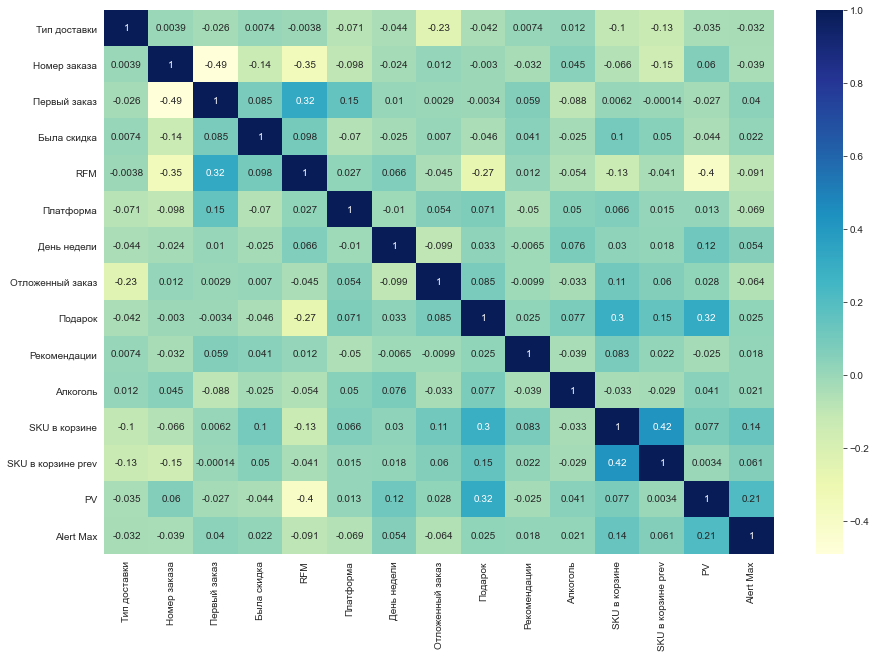

In [708]:
fig, ax = plt.subplots(figsize=(15,10)) 
corr = df_corr.corr()
sb.heatmap(corr, cmap="YlGnBu", annot=True, ax=ax)

### Линейная регрессия

In [709]:
y = df["cnt_items"]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              cnt_items   R-squared (uncentered):                   0.744
Model:                            OLS   Adj. R-squared (uncentered):              0.743
Method:                 Least Squares   F-statistic:                              500.1
Date:                Tue, 28 Dec 2021   Prob (F-statistic):                        0.00
Time:                        14:07:23   Log-Likelihood:                         -8324.4
No. Observations:                2423   AIC:                                  1.668e+04
Df Residuals:                    2409   BIC:                                  1.676e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
id_deliverytype         0.0044      0.225      0.019      0.985      -0.436       0.445
creator_request_num     0.0234      0.034      0.698      0.485      -0.042       0.089
first_order             0.0155      0.371      0.042      0.967      -0.712       0.743
use_discount            2.1207      0.373      5.688      0.000       1.390       2.852
rfm                    -0.0558      0.030     -1.849      0.065      -0.115       0.003
platform                0.9685      0.251      3.865      0.000       0.477       1.460
dow_dateopen            0.1817      0.085      2.150      0.032       0.016       0.348
delayed_order           1.9492      0.470      4.146      0.000       1.027       2.871
gift_extra_num          6.6184      0.581     11.382      0.000       5.478       7.759
is_recommended          2.1757      0.541      4.024      0.000       1.115       3.236
is_alcoholic           -0.8767      0.400     -2.190      0.029      -1.662      -0.092
prev_cnt_items          0.6680      0.030     22.498      0.000       0.610       0.726
pv                      0.0239      0.009      2.663      0.008       0.006       0.041
alert_max_item          2.5516      0.408      6.247      0.000       1.751       3.353
==============================================================================
Omnibus:                     2603.422   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           654152.361
Skew:                           4.843   Prob(JB):                         0.00
Kurtosis:                      82.910   Cond. No.                         291.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Логистическая регрессия

In [712]:
X = df.loc[:, ~df.columns.isin(['target_logreg', 'cnt_items', 'date', 
                                'id_request', 'user_id', 'productcost_amount', 
                                'productcost_without_discount_amount'])]

In [713]:
y = df["target_logreg"]

In [715]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [716]:
logreg_model = LogisticRegression(random_state=128, max_iter=1000)

#### Выбираем лучшую модель на кросс-валидации

In [717]:
optimization_dict = {'class_weight':['balanced', None],
                     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                     'C': [0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 2, 4, 5, 10, 15, 20]
                     }

model = GridSearchCV(logreg_model, optimization_dict, 
                     scoring='accuracy', n_jobs = -1, cv = 8)

model.fit(X_train, y_train)

print(model.best_score_)
print(model.best_params_)

0.7086010315808524
{'C': 1, 'class_weight': None, 'solver': 'lbfgs'}


In [719]:
lg_tuned_model =  LogisticRegression(solver='lbfgs',
                                     C=1,
                                     random_state=128,
                                     n_jobs=-1)

lg_tuned_model.fit(X_train, y_train)

importances = abs(lg_tuned_model.coef_[0])
importances = 100.0 * (importances / importances.max())

indices = np.argsort(importances)[::-1]

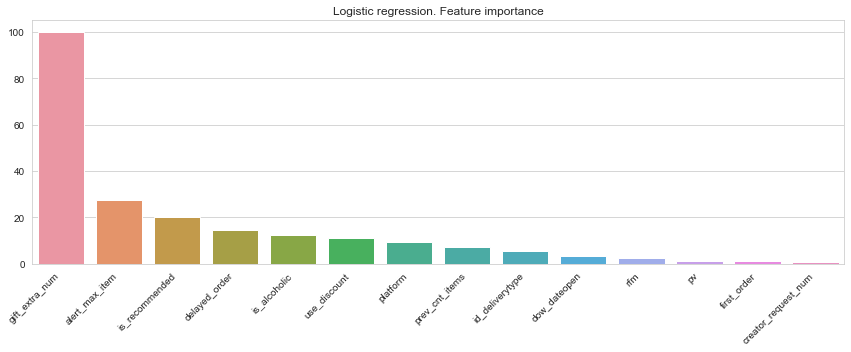

In [721]:
draw_plot_feature_importance(X_train, indices, "Logistic regression. Feature importance")

#### Градиентный бустинг

In [722]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

#### Выбиарем лучшую модель на кросс-валидации

In [723]:
xgb_model = XGBClassifier(random_state=128)

optimization_dict = {'n_estimators': [300, 500],
                     'max_depth': [6, 10],
                     'learning_rate': [0.001, 0.01, 0.03],
                     'gamma': [0, 1],
                     'min_child_weight':[3, 9],
                     'subsample': [0.5, 0.9]
                     }

model = GridSearchCV(xgb_model, optimization_dict, 
                     scoring='accuracy', verbose=1, n_jobs=-1, cv=3)


model.fit(X_train, y_train)
print(model.best_score_)
print(model.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  4.5min finished
/Users/aryzhkov/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:18:27] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7430689056658223
{'gamma': 1, 'learning_rate': 0.001, 'max_depth': 10, 'min_child_weight': 9, 'n_estimators': 500, 'subsample': 0.9}


In [725]:
xgb_tuned_model =  XGBClassifier(n_estimators=500,
                               max_depth=10,
                               learning_rate=0.001,
                               gamma=1,
                               min_child_weight=9,
                               subsample=0.9,
                               random_state=64)
xgb_tuned_model.fit(X_train, y_train)

y_pred = xgb_tuned_model.predict(X_test)

[14:21:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[14:21:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


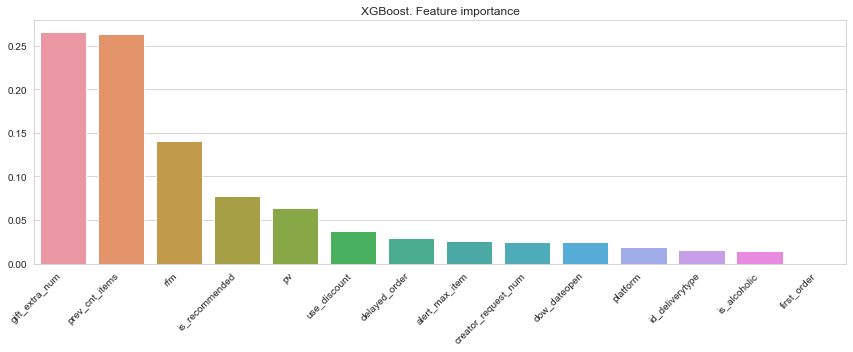

In [726]:
xgb_tuned_model.fit(X_train, y_train)

importances = xgb_tuned_model.feature_importances_
indices = np.argsort(importances)[::-1]

draw_plot_feature_importance(X_train, indices, "XGBoost. Feature importance")

In [730]:
# y_pred = xgb_tuned_model.predict(X_test)
# test = pd.DataFrame(y_test)
# test['preds'] = y_pred
# df_out = pd.merge(df, test[['preds']], how = 'left', left_index = True, right_index = True)

# df_out[df_out["preds"] >= 0].head(40)

## Прогноз без учета новогоднего подарка

##### Забираем все данные до начала акции

In [731]:
df_without_gift = df[df['date'] < '2021-12-14']

In [732]:
df_without_gift.groupby(["gift_extra_num"]).count().reset_index()["gift_extra_num"]

0    0
Name: gift_extra_num, dtype: int64

In [733]:
X = df.loc[:, ~df.columns.isin(['target_logreg', 'cnt_items', 'date', 
                                'id_request', 'user_id', 'productcost_amount', 
                                'productcost_without_discount_amount', 'gift_extra_num', 'alert_max_item'])]

##### Линрег

In [734]:
y = df["cnt_items"]

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              cnt_items   R-squared (uncentered):                   0.727
Model:                            OLS   Adj. R-squared (uncentered):              0.725
Method:                 Least Squares   F-statistic:                              534.1
Date:                Tue, 28 Dec 2021   Prob (F-statistic):                        0.00
Time:                        14:24:58   Log-Likelihood:                         -8403.9
No. Observations:                2423   AIC:                                  1.683e+04
Df Residuals:                    2411   BIC:                                  1.690e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
id_deliverytype        -0.2105      0.231     -0.910      0.363      -0.664       0.243
creator_request_num    -0.0220      0.034     -0.639      0.523      -0.089       0.046
first_order             0.2380      0.383      0.622      0.534      -0.513       0.989
use_discount            1.9817      0.385      5.150      0.000       1.227       2.736
rfm                    -0.1754      0.030     -5.925      0.000      -0.234      -0.117
platform                0.9585      0.258      3.720      0.000       0.453       1.464
dow_dateopen            0.1980      0.087      2.268      0.023       0.027       0.369
delayed_order           1.9832      0.483      4.103      0.000       1.035       2.931
is_recommended          2.3859      0.558      4.274      0.000       1.291       3.481
is_alcoholic           -0.5434      0.413     -1.317      0.188      -1.353       0.266
prev_cnt_items          0.7037      0.031     23.050      0.000       0.644       0.764
pv                      0.0536      0.009      6.019      0.000       0.036       0.071
==============================================================================
Omnibus:                     2652.706   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           693541.378
Skew:                           5.002   Prob(JB):                         0.00
Kurtosis:                      85.277   Cond. No.                         269.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Логрег

In [735]:
y = df["target_logreg"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [736]:
optimization_dict = {'class_weight':['balanced', None],
                     'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                     'C': [0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 2, 4, 5, 10, 15, 20]
                     }

model = GridSearchCV(lg_model, optimization_dict, 
                     scoring='accuracy', n_jobs=-1, cv=8)

model.fit(X_train, y_train)

print(model.best_score_)
print(model.best_params_)

0.6925881519017887
{'C': 1, 'class_weight': None, 'solver': 'liblinear'}


In [737]:
lg_tuned_model =  LogisticRegression(solver='liblinear',
                                     C=1,
                                     random_state=128,
                                     n_jobs=-1)

lg_tuned_model.fit(X_train, y_train)

importances = abs(lg_tuned_model.coef_[0])
importances = 100.0 * (importances / importances.max())

indices = np.argsort(importances)[::-1]

/Users/aryzhkov/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


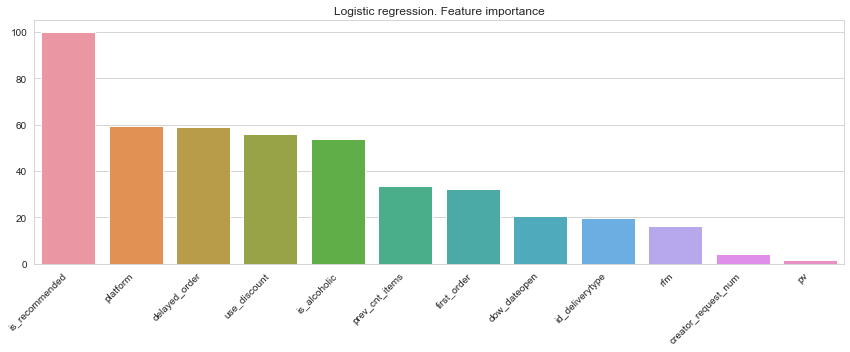

In [738]:
draw_plot_feature_importance(X_train, indices, "Logistic regression. Feature importance")

##### Бустинг

In [739]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [740]:
xgb_model = XGBClassifier(random_state = 64)

optimization_dict = {'n_estimators': [300, 500],
                     'max_depth': [6, 10],
                     'learning_rate': [0.001, 0.01, 0.03],
                     'gamma': [0, 1],
                     'min_child_weight':[3, 9],
                     'subsample': [0.5, 0.9]
                     }

model = GridSearchCV(xgb_model, optimization_dict, 
                     scoring='accuracy', verbose = 1, n_jobs = -1, cv = 3)


model.fit(X_train, y_train)
print(model.best_score_)
print(model.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed:  3.4min finished
/Users/aryzhkov/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7265678157309918
{'gamma': 0, 'learning_rate': 0.001, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.5}


In [747]:
xgb_tuned_model = XGBClassifier(n_estimators=500,
                               max_depth=10,
                               learning_rate=0.001,
                               gamma=0,
                               min_child_weight=3,
                               subsample=0.5,
                               random_state=64)

xgb_tuned_model.fit(X_train, y_train)

y_pred = xgb_tuned_model.predict(X_test)

[14:39:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[14:40:16] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


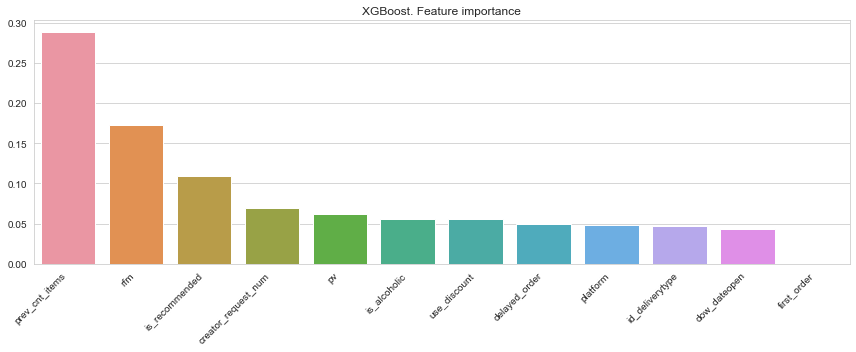

In [750]:
xgb_tuned_model.fit(X_train, y_train)

importances = xgb_tuned_model.feature_importances_
indices = np.argsort(importances)[::-1]

draw_plot_feature_importance(X_train, indices, "XGBoost. Feature importance")

### Отложенные заказы, алкоголь, платформа

In [752]:
df.groupby(["delayed_order"]).agg({"cnt_items": "mean"}).reset_index()

,delayed_order,cnt_items
0,0,11.605989
1,1,14.454545


In [753]:
df.groupby(["is_alcoholic"]).agg({"cnt_items": "mean"}).reset_index()

,is_alcoholic,cnt_items
0,0,12.117290
1,1,11.375281


In [754]:
df.groupby(["is_alcoholic"]).agg({"productcost_amount": "mean"}).reset_index()

,is_alcoholic,productcost_amount
0,0,22.334590
1,1,29.168876


In [755]:
df.groupby(["platform"]).agg({"cnt_items": "mean"}).reset_index()

,platform,cnt_items
0,0,11.693642
1,1,12.005806
2,2,14.412429
